In [1]:
%env KERAS_BACKEND = tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from ipywidgets import interact, FloatSlider, IntSlider

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Lambda
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras import metrics
from keras.datasets import mnist
from keras.utils import np_utils
from keras import backend as K

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# 載入資料、修改維度並標準化

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

In [5]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

x_test -= x_test.min()
x_test = x_test/x_test.max()

# 建立VAE

In [6]:
enc_1 = Dense(100, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [7]:
x = Input(shape=(784,))

enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

# 常態取樣

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

## 使用Lambda使其為 keras的layer

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [10]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

# VAE Model

In [11]:
VAE = Model(x,x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          78500       input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            202         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

# 自訂義Loss function

In [12]:
def vae_loss(x, x_recon):
    recoery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    KL_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recoery_loss+KL_loss

# 載入自己訓練的權重

In [13]:
VAE.load_weights('VAE_model_weights.h5')

In [14]:
VAE.compile(loss=vae_loss, optimizer='adam')

In [15]:
VAE.fit(x_train, x_train, batch_size=32, epochs=50)

Epoch 1/50
60000/60000 [==============================] - 13s 209us/step - loss: 142.8781
Epoch 2/50
60000/60000 [==============================] - 12s 198us/step - loss: 142.8474
Epoch 3/50
60000/60000 [==============================] - 12s 196us/step - loss: 142.8080
Epoch 4/50
60000/60000 [==============================] - 12s 197us/step - loss: 142.7655
Epoch 5/50
60000/60000 [==============================] - 13s 216us/step - loss: 142.7701
Epoch 6/50
60000/60000 [==============================] - 13s 208us/step - loss: 142.7239
Epoch 7/50
60000/60000 [==============================] - 15s 244us/step - loss: 142.6530
Epoch 8/50
60000/60000 [==============================] - 13s 216us/step - loss: 142.7011
Epoch 9/50
60000/60000 [==============================] - 13s 217us/step - loss: 142.6084
Epoch 10/50
60000/60000 [==============================] - 11s 179us/step - loss: 142.6485
Epoch 11/50
60000/60000 [==============================] - 12s 192us/step - loss: 142.5655
Epoch 12

## 將模型以及權重存下

In [16]:
model_json = VAE.to_json()
open('VAE_model.json','w').write(model_json)
VAE.save_weights('VAE_model_weights.h5')

# VAE 的 Encoder

In [17]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


# VAE 的 Decoder

In [18]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


In [19]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 29552 圖的 latent 表示為 [[ 0.31695116 -0.71402824]]


## 隨機取3000筆資料

In [20]:
indices = np.random.randint(x_test.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

# 使用Encoder將測試資料轉換成二維的狀態(latent)並畫出其分布圖

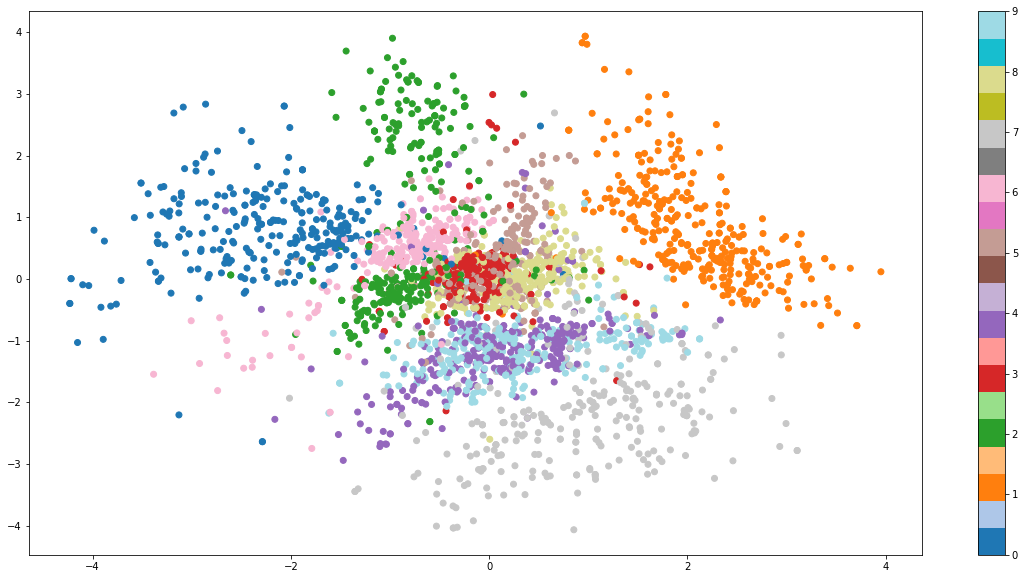

In [21]:
plt.figure(figsize=(20, 10))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

# 使用Decoder將資料還原

In [22]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [23]:
n=15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))

grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

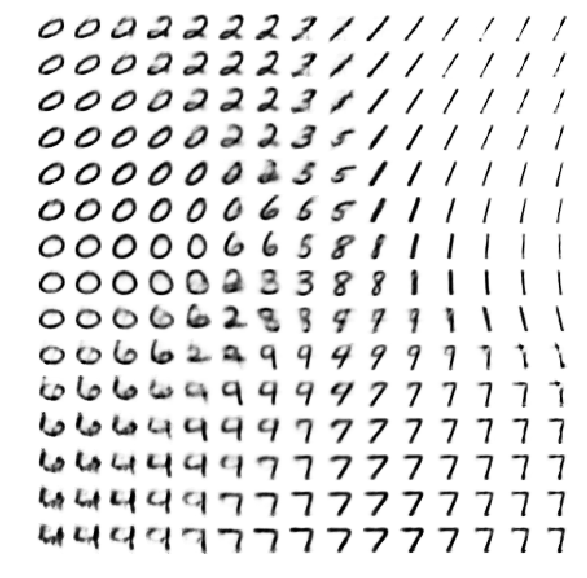

In [24]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

# 使用Interact來決定要呈現的數字，且動態顯示數字變化的樣子

In [59]:
def inBetween(t):
    data_0 = x_train0[start_num]
    data_1 = x_train0[end_num]
    data_t = (1-t)*x_train0[start_num] + t*x_train0[end_num]

    mu_0 = VAE_Encoder.predict(x_train[start_num:start_num+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[end_num:end_num+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(20, 10))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1],label='start')
    ax1.scatter(mu_1[0], mu_1[1],label='end')
    ax1.scatter(mu_t[0], mu_t[1],label='move')
    ax1.annotate('(' + str(mu_0[0]) + ', ' + str(mu_0[1]) + ')', (mu_0[0], mu_0[1]),fontsize=20)
    ax1.annotate('(' + str(mu_1[0]) + ', ' + str(mu_1[1]) + ')', (mu_1[0], mu_1[1]),fontsize=20)
    ax1.annotate('(' + str(mu_t[0]) + ', ' + str(mu_t[1]) + ')', (mu_t[0], mu_t[1]),fontsize=20)
    ax1.plot([mu_0[0], mu_1[0]], [mu_0[1], mu_1[1]], ls='--', alpha=0.5,)
    ax1.legend(fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid()

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='OrRd')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='YlGnBu')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='YlOrRd')

## 選擇要呈現的數字

In [60]:
def choose_num(start, end):
    global start_num
    global end_num
    while(1):
        start_num = np.random.randint(y_train0.shape[0])
        if start == y_train0[start_num]:
            end_num = np.random.randint(y_train0.shape[0])
            if end == y_train0[end_num]:
                break
    interact(inBetween, t=FloatSlider(value=0.5, min=0, max=1.0,step=0.02))

In [61]:
interact(choose_num,start=IntSlider(value=0, min=0, max=9),end=IntSlider(value=9, min=0, max=9))

interactive(children=(IntSlider(value=0, description='start', max=9), IntSlider(value=9, description='end', ma…

<function __main__.choose_num(start, end)>